In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [2]:
train_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [3]:
test_transform = torchvision.transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [4]:
train_data = torchvision.datasets.ImageFolder(root=r"C:\Users\utkri\OneDrive\Documents\Python_datasets\pizza_steak\train", 
                                              transform=train_transform)

In [5]:
test_data = torchvision.datasets.ImageFolder(root= r"C:\Users\utkri\OneDrive\Documents\Python_datasets\pizza_steak\test", 
                                                transform= test_transform)

In [6]:
len(train_data)

1500

In [7]:
len(test_data)

500

In [8]:
class_names = train_data.classes
class_names

['pizza', 'steak']

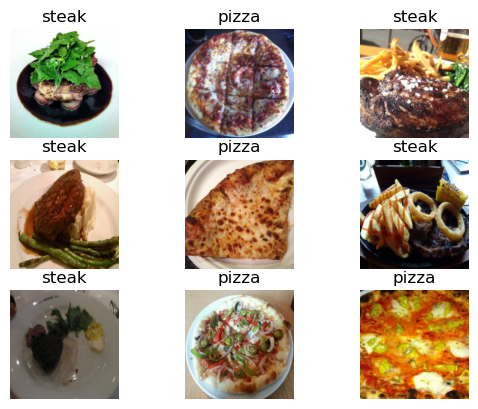

In [9]:
# Let's visualize the image 
fig, ax = plt.subplots(nrows=3, ncols=3)

for i in range(3):
    for j in range(3):
        random_idx = torch.randint(0, len(train_data), size=[1]).item()
        ax[i,j].imshow(np.transpose(train_data[random_idx][0],(1,2,0)))
        ax[i,j].set_title(class_names[train_data[random_idx][1]])
        ax[i,j].axis(False)

In [10]:
len(train_data)

1500

In [11]:
1500/32

46.875

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

In [13]:
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

In [14]:
next_train_data, next_train_label = next(iter(train_data))

In [15]:
next_train_data.shape, next_train_label

(torch.Size([3, 224, 224]), 0)

Text(0.5, 1.0, 'pizza')

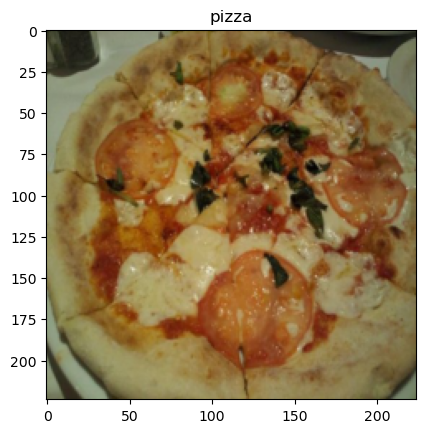

In [16]:
plt.imshow(np.transpose(next_train_data,(1,2,0)))
plt.title(f"{class_names[next_train_label]}")

In [17]:
# Make a model 
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels =6, out_channels=16, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*54*54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16*54*54)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [19]:
model = Model().to(device)

In [20]:
# Define the loss function and the criterion 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
def accuracy_fn(y_val, y_test):
    corr = torch.eq(y_val,y_test).sum().item() 
    acc = (corr / len(y_test)) * 100
    return acc

In [22]:
len(train_dataloader.dataset) / 32

46.875

In [23]:
len(test_dataloader), len(test_dataloader.dataset)

(16, 500)

In [24]:
import time 
start_time = time.time()

# Train the model 
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    print(f"Epoch: {epoch}\n --------------")
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print 
        if batch%40==0:
            print(f"Looked at: {batch * len(X_train)} / {len(train_dataloader.dataset)} samples.")

    train_loss = train_loss / len(train_dataloader)


    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_val = model(X_test)
            test_loss += criterion(y_val, y_test)
            test_acc += accuracy_fn(y_test, y_val.argmax(axis=1))

        test_loss = test_loss / len(test_dataloader)
        test_acc = test_acc / len(test_dataloader)

    print(f"Testing Loss: {test_loss} Testing Accuracy: {test_acc} \n ")

end_time = time.time()

print(f"Final time taken to run the model is: {end_time - start_time} seconds.")

Epoch: 0
 --------------
Looked at: 0 / 1500 samples.
Looked at: 1280 / 1500 samples.
Testing Loss: 0.40961015224456787 Testing Accuracy: 82.890625 
 
Epoch: 1
 --------------
Looked at: 0 / 1500 samples.
Looked at: 1280 / 1500 samples.
Testing Loss: 0.3687412738800049 Testing Accuracy: 85.5078125 
 
Epoch: 2
 --------------
Looked at: 0 / 1500 samples.
Looked at: 1280 / 1500 samples.
Testing Loss: 0.37376099824905396 Testing Accuracy: 83.046875 
 
Epoch: 3
 --------------
Looked at: 0 / 1500 samples.
Looked at: 1280 / 1500 samples.
Testing Loss: 0.36445409059524536 Testing Accuracy: 82.7734375 
 
Epoch: 4
 --------------
Looked at: 0 / 1500 samples.
Looked at: 1280 / 1500 samples.
Testing Loss: 0.35008683800697327 Testing Accuracy: 83.828125 
 
Final time taken to run the model is: 53.94455313682556 seconds.
